In [221]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, Dropout
from keras.callbacks import TensorBoard
import keras.metrics
from sklearn.model_selection import train_test_split

### Data exploration

In [181]:
df = pd.read_csv('./data/aapl.csv')
df.index = pd.DatetimeIndex(df.date)
df.drop('date', axis=1, inplace=True)

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2014-06-23 to 2019-06-21
Data columns (total 9 columns):
open                1259 non-null float64
close               1259 non-null float64
low                 1259 non-null float64
high                1259 non-null float64
open_normalized     1259 non-null float64
close_normalized    1259 non-null float64
low_normalized      1259 non-null float64
high_normalized     1259 non-null float64
filterred           1259 non-null float64
dtypes: float64(9)
memory usage: 98.4 KB


In [183]:
df.describe()

,open,close,low,high,open_normalized,close_normalized,low_normalized,high_normalized,filterred
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000
mean,140.765218,140.811311,139.532454,142.013042,0.360600,0.356381,0.356799,0.359411,0.348219
std,36.410167,36.438227,36.085385,36.769071,0.258632,0.256987,0.257183,0.257541,0.261587
min,90.000000,90.280000,89.470000,90.700000,0.000000,0.000000,0.000000,0.000000,0.006933
25%,110.160000,109.970000,108.945000,111.435000,0.143202,0.138867,0.138800,0.145234,0.123324
50%,128.860000,128.770000,128.150000,129.690000,0.276034,0.271458,0.275675,0.273097,0.259694
75%,171.320000,171.180000,169.800000,172.905000,0.577639,0.570562,0.572518,0.575786,0.571488
max,230.780000,232.070000,229.780000,233.470000,1.000000,1.000000,1.000000,1.000000,0.960995


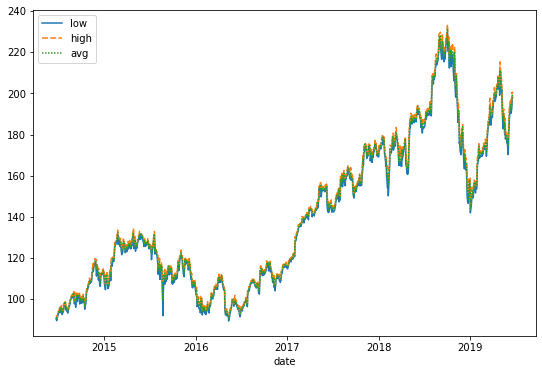

In [184]:
df['avg'] = (df.open + df.close + df.low + df.high) / 4
fig = plt.figure(figsize=(9,6))
sns.lineplot(data=df[['low', 'high', 'avg']], ci=False)
plt.show()

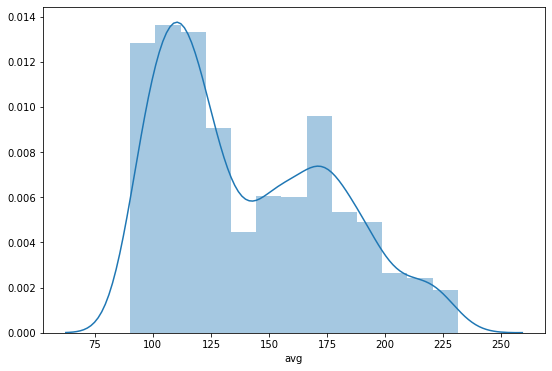

In [185]:
fig = plt.figure(figsize=(9,6))
sns.distplot(df.avg)
plt.show()

### Feature selection

In [186]:
df.drop(['close', 'close_normalized'], axis=1, inplace=True)
df.head()

,open,low,high,open_normalized,low_normalized,high_normalized,filterred,avg
date,,,,,,,,
2014-06-23,91.32,90.60,91.62,0.009376,0.008054,0.006444,0.006938,91.0925
2014-06-24,90.75,90.19,91.74,0.005327,0.005131,0.007284,0.006938,90.7400
2014-06-25,90.21,89.65,90.70,0.001492,0.001283,0.000000,0.006935,90.2300
2014-06-26,90.37,89.80,91.05,0.002628,0.002352,0.002451,0.006933,90.5300
2014-06-27,90.82,90.77,92.00,0.005825,0.009265,0.009106,0.006935,91.3925


In [187]:
df['avg_normalized'] = (df.avg - df.avg.min()) / (df.avg.max() - df.avg.min())
df.head()

,open,low,high,open_normalized,low_normalized,high_normalized,filterred,avg,avg_normalized
date,,,,,,,,,
2014-06-23,91.32,90.60,91.62,0.009376,0.008054,0.006444,0.006938,91.0925,0.006112
2014-06-24,90.75,90.19,91.74,0.005327,0.005131,0.007284,0.006938,90.7400,0.003614
2014-06-25,90.21,89.65,90.70,0.001492,0.001283,0.000000,0.006935,90.2300,0.000000
2014-06-26,90.37,89.80,91.05,0.002628,0.002352,0.002451,0.006933,90.5300,0.002126
2014-06-27,90.82,90.77,92.00,0.005825,0.009265,0.009106,0.006935,91.3925,0.008238


In [188]:
data = df[df.columns[3:]]

### Train test split

In [213]:
N_STEPS_LOOKAHEAD = 1
N_FEATURES = data.values.shape[1]
N_SAMPLES = data.values.shape[0]
x = data.values[:-N_STEPS_LOOKAHEAD].reshape(-1, 1, N_FEATURES)
x_test = x[-30:]
x = x[:-30]
y = data.values[N_STEPS_LOOKAHEAD:].reshape(-1, 1, N_FEATURES)
y_test = y[-30:]
y = y[:-30]
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, shuffle=False)

### Modelling

In [201]:
model = Sequential(name='baseline', layers=[
    Conv1D(filters=128, 
           kernel_size=3, 
           input_shape=(1, N_FEATURES),
           padding='same'),
    LSTM(units=64,
         activation='sigmoid',
         return_sequences=True),
    Dense(units=256, activation='sigmoid'),
    Dropout(0.4)
    Dense(units=N_FEATURES, activation='linear')
])

callbacks = [
    TensorBoard()
]

model.compile(optimizer='sgd', 
              loss='mean_absolute_error', 
              metrics=[keras.metrics.mae, 
                       keras.metrics.kullback_leibler_divergence])

In [219]:
model.fit(x=x_train, 
          y=y_train, 
          epochs=100,
          validation_data=(x_val, y_val),
          callbacks=callbacks)

Train on 1043 samples, validate on 185 samples
Epoch 1/100
1043/1043 [==============================] - 0s 93us/step - loss: 3.3826 - mean_absolute_error: 3.3826 - kullback_leibler_divergence: 0.3857 - val_loss: 9.6023 - val_mean_absolute_error: 9.6023 - val_kullback_leibler_divergence: 1.6239
Epoch 2/100
1043/1043 [==============================] - 0s 95us/step - loss: 3.4607 - mean_absolute_error: 3.4607 - kullback_leibler_divergence: 0.5923 - val_loss: 10.7273 - val_mean_absolute_error: 10.7273 - val_kullback_leibler_divergence: 3.0083
Epoch 3/100
1043/1043 [==============================] - 0s 94us/step - loss: 3.3682 - mean_absolute_error: 3.3682 - kullback_leibler_divergence: 0.2898 - val_loss: 11.0458 - val_mean_absolute_error: 11.0458 - val_kullback_leibler_divergence: 2.8188
Epoch 4/100
1043/1043 [==============================] - 0s 94us/step - loss: 3.4695 - mean_absolute_error: 3.4695 - kullback_leibler_divergence: 0.3869 - val_loss: 10.4504 - val_mean_absolute_error: 10.45

In [232]:
y_pred = model.predict(x_test)
mean_absolute_error(y_test[:,0], y_pred[:,0])

8.704332874846148